In [3]:
from google.cloud import bigquery

client = bigquery.Client()

In [4]:
sql = """
SELECT * from fe_hackathon_ldn_24.berlin_race10_telemetry
;
"""
Berlin_race_10_data = client.query(sql).to_dataframe()

Berlin_race_10_data.head()

,city,sequence,sessionname,time,drivername,car_number,tv_acc_x,tv_acc_y,tv_steer,tv_brake,tv_gps_head,tv_gps_lat,tv_gps_long,tv_speed,tv_yaw_rate
0,BER,10,Race,2024-05-12 13:03:07.534000+00:00,"DENNIS, Jake",1,-0.184,0.047,2183.9,17.0,47.83372,52.480017,13.392943,15.78,-1.405
1,BER,10,Race,2024-05-12 13:03:07.584000+00:00,"DENNIS, Jake",1,-0.245,0.005,2188.6,17.0,47.83372,52.480020,13.392948,15.67,-1.405
2,BER,10,Race,2024-05-12 13:03:08.338000+00:00,"DENNIS, Jake",1,-0.171,0.062,2195.2,11.0,47.50113,52.480035,13.392977,12.22,1.161
3,BER,10,Race,2024-05-12 13:03:08.384000+00:00,"DENNIS, Jake",1,-0.152,0.043,2195.1,12.0,47.45835,52.480038,13.392981,12.06,1.161
4,BER,10,Race,2024-05-12 13:11:18.740000+00:00,"DENNIS, Jake",1,-0.562,0.481,1109.2,57.0,216.85422,52.480375,13.391335,185.79,-1.527


In [5]:
sql = """
SELECT * from fe_hackathon_ldn_24.berlin_race9_telemetry
;
"""
Berlin_race_9_data = client.query(sql).to_dataframe()

Berlin_race_9_data.head()

,city,sequence,sessionname,time,drivername,car_number,tv_acc_x,tv_acc_y,tv_steer,tv_brake,tv_gps_head,tv_gps_lat,tv_gps_long,tv_speed,tv_yaw_rate
0,BER,9,Race,2024-05-11 13:03:40.302000+00:00,"DENNIS, Jake",1,-0.021,0.078,3276.7,9.0,47.14096,52.479165,13.391210,16.03,0.672
1,BER,9,Race,2024-05-11 13:18:32.527000+00:00,"DENNIS, Jake",1,-0.334,0.068,3276.7,40.0,268.65608,52.482312,13.395855,38.87,3.177
2,BER,9,Race,2024-05-11 13:54:19.352000+00:00,"DENNIS, Jake",1,0.746,1.608,3276.7,41.0,164.45111,52.481996,13.395312,74.68,3.177
3,BER,9,Race,2024-05-11 13:54:19.403000+00:00,"DENNIS, Jake",1,-0.677,1.596,3276.7,66.0,160.93564,52.481978,13.395322,73.23,3.788
4,BER,9,Race,2024-05-11 13:54:19.502000+00:00,"DENNIS, Jake",1,-0.492,0.718,3276.7,64.0,157.28610,52.481961,13.395333,72.46,4.521


In [6]:
!pip install langchain==0.0.332

In [7]:
#import google.cloud.bigquery as bq
import langchain
from google.cloud import aiplatform
from langchain.llms import VertexAI
from langchain.document_loaders import BigQueryLoader
from langchain.prompts import PromptTemplate
from langchain.schema import format_document

# Print LangChain and Vertex AI versions
print(f"LangChain version: {langchain.__version__}")
print(f"Vertex AI SDK version: {aiplatform.__version__}")

LangChain version: 0.0.332
Vertex AI SDK version: 1.59.0


In [8]:
#You will need to initialize vertexai with your project_id and location:

PROJECT_ID = "formula-e-shared24lon-123"
LOCATION = "us-west1"

import vertexai
vertexai.init(project=PROJECT_ID, location=LOCATION)

In [9]:
#llm = VertexAI(model_name="text-bison", temperature=0)
#llm = VertexAI(model_name="code-bison@latest", max_output_tokens=2048)
#llm("What is BigQuery?")

In [10]:
#llm = VertexAI(model_name="gemini-1.5-flash-001", temperature=0)
#llm("What is BigQuery?")

In [11]:
#from langchain_google_vertexai import ChatVertexAI

llm = VertexAI(
    model="gemini-1.5-flash-001",
    temperature=1,
    max_tokens=None,
    max_retries=6,
    stop=None,
    # other params...
)

In [12]:
llm("What is BigQuery?")

' **BigQuery** is a cloud-based, managed data warehouse that allows users to store, query, and analyze large datasets. It is designed for businesses of all sizes and is used by companies such as Google, Spotify, and Twitter.\n\n**Key features of BigQuery include:**\n\n* **Scalability:** BigQuery can handle datasets of any size, from a few gigabytes to multiple terabytes.\n* **Speed:** BigQuery is extremely fast, with queries often completing in seconds or even milliseconds.\n* **Reliability:** BigQuery is a highly reliable service, with a 99.9% uptime guarantee.\n'

In [13]:
# Define our query
# specifically targeting meta data of the tables involved
# this pulls back all of the metadata for the tables in the database in question
# which the 'chain' object can use to help the model generate queries from english language statements
query = f"""
SELECT table_name, ddl
FROM `formula-e-shared24lon-123.fe_hackathon_ldn_24.INFORMATION_SCHEMA.TABLES`
WHERE table_type = 'BASE TABLE'
ORDER BY table_name;
"""
# Load the data
loader = BigQueryLoader(
    query, metadata_columns="table_name", page_content_columns="ddl"
)
# create a 'load' object from the BigQueryLoader function
data = loader.load()


In [43]:
# we will get the prompt specific input from a streamlit input box
#issue = st.text_input("Enter the medical issue description:")
querypromptcontent  = "for car number 18 what was the fastest speed in race 9?"

In [44]:
# Use code generation model
#llm = VertexAI(model_name="code-bison@latest", max_output_tokens=2048)
llm = VertexAI(model_name="text-bison", temperature=0)

# Define the chain
chain = (
    {
        "content": lambda docs: "\n\n".join(
            format_document(doc, PromptTemplate.from_template("{page_content}"))
            for doc in docs
        )
    }
    | PromptTemplate.from_template(
        f"""Suggest a GoogleSQL query to {querypromptcontent}:\n\n{{content}}"""
    )
    | llm
)

# Invoke the chain with the documents, and remove code backticks
# chain object (combination of user prompt and llm model) uses metadata to dynamically create query
generatedquery = chain.invoke(data).strip("```")
#generatedquery = chain.invoke(data)
generatedquery = generatedquery[7:10000]
#generatedquery =  f'"""{generatedquery}"""'
print(generatedquery)

# need to put some error trapping around the query definition because sometimes following on from the
# user prompt the ai writes the query out incorrectly - i.e. it gets the field names incorrect at times!
df2 = client.query(generatedquery).to_dataframe()
df2.head()




SELECT MAX(tv_speed) AS fastest_speed
FROM `formula-e-shared24lon-123.fe_hackathon_ldn_24.berlin_race9_telemetry`
WHERE car_number = 18;



,fastest_speed
0,246.91


In [16]:
# we will get the prompt specific input from a streamlit input box
#issue = st.text_input("Enter the medical issue description:")
querypromptcontent  = "who was the fastest driver in race 9 and also display the speed?"

In [17]:
# Use code generation model
#llm = VertexAI(model_name="code-bison@latest", max_output_tokens=2048)
llm = VertexAI(model_name="text-bison", temperature=0)

# Define the chain
chain = (
    {
        "content": lambda docs: "\n\n".join(
            format_document(doc, PromptTemplate.from_template("{page_content}"))
            for doc in docs
        )
    }
    | PromptTemplate.from_template(
        f"""Suggest a GoogleSQL query to {querypromptcontent}:\n\n{{content}}"""
    )
    | llm
)

# Invoke the chain with the documents, and remove code backticks
# chain object (combination of user prompt and llm model) uses metadata to dynamically create query
generatedquery = chain.invoke(data).strip("```")
#generatedquery = chain.invoke(data)
generatedquery = generatedquery[7:10000]
#generatedquery =  f'"""{generatedquery}"""'
print(generatedquery)

# need to put some error trapping around the query definition because sometimes following on from the
# user prompt the ai writes the query out incorrectly - i.e. it gets the field names incorrect at times!
df2 = client.query(generatedquery).to_dataframe()
df2.head()



SELECT drivername, MAX(tv_speed) AS max_speed
FROM `formula-e-shared24lon-123.fe_hackathon_ldn_24.berlin_race9_telemetry`
GROUP BY drivername
ORDER BY max_speed DESC
LIMIT 1;



,drivername,max_speed
0,"NATO, Norman",251.2


In [18]:
# we will get the prompt specific input from a streamlit input box
#issue = st.text_input("Enter the medical issue description:")
querypromptcontent  = "highest speed for drivername 'NATO, Norman' in race 10?"

In [19]:
# Use code generation model
#llm = VertexAI(model_name="code-bison@latest", max_output_tokens=2048)
llm = VertexAI(model_name="text-bison", temperature=0)

# Define the chain
chain = (
    {
        "content": lambda docs: "\n\n".join(
            format_document(doc, PromptTemplate.from_template("{page_content}"))
            for doc in docs
        )
    }
    | PromptTemplate.from_template(
        f"""Suggest a GoogleSQL query to {querypromptcontent}:\n\n{{content}}"""
    )
    | llm
)

# Invoke the chain with the documents, and remove code backticks
# chain object (combination of user prompt and llm model) uses metadata to dynamically create query
generatedquery = chain.invoke(data).strip("```")
#generatedquery = chain.invoke(data)
generatedquery = generatedquery[7:10000]
#generatedquery =  f'"""{generatedquery}"""'
print(generatedquery)

# need to put some error trapping around the query definition because sometimes following on from the
# user prompt the ai writes the query out incorrectly - i.e. it gets the field names incorrect at times!
df2 = client.query(generatedquery).to_dataframe()
df2.head()



SELECT
  MAX(tv_speed) AS max_speed
FROM
  `formula-e-shared24lon-123.fe_hackathon_ldn_24.berlin_race10_telemetry`
WHERE
  drivername = 'NATO, Norman';



,max_speed
0,248.0


In [20]:
# we will get the prompt specific input from a streamlit input box
#issue = st.text_input("Enter the medical issue description:")
querypromptcontent  = "who was the fastest driver in race 10 and also display the speed?"

In [21]:
# Use code generation model
#llm = VertexAI(model_name="code-bison@latest", max_output_tokens=2048)
llm = VertexAI(model_name="text-bison", temperature=0)

# Define the chain
chain = (
    {
        "content": lambda docs: "\n\n".join(
            format_document(doc, PromptTemplate.from_template("{page_content}"))
            for doc in docs
        )
    }
    | PromptTemplate.from_template(
        f"""Suggest a GoogleSQL query to {querypromptcontent}:\n\n{{content}}"""
    )
    | llm
)

# Invoke the chain with the documents, and remove code backticks
# chain object (combination of user prompt and llm model) uses metadata to dynamically create query
generatedquery = chain.invoke(data).strip("```")
#generatedquery = chain.invoke(data)
generatedquery = generatedquery[7:10000]
#generatedquery =  f'"""{generatedquery}"""'
print(generatedquery)

# need to put some error trapping around the query definition because sometimes following on from the
# user prompt the ai writes the query out incorrectly - i.e. it gets the field names incorrect at times!
df2 = client.query(generatedquery).to_dataframe()
df2.head()



SELECT drivername, MAX(tv_speed) AS max_speed
FROM `formula-e-shared24lon-123.fe_hackathon_ldn_24.berlin_race10_telemetry`
GROUP BY drivername
ORDER BY max_speed DESC
LIMIT 1;



,drivername,max_speed
0,"VERGNE, Jean-Éric",253.72


In [49]:
# we will get the prompt specific input from a streamlit input box
#issue = st.text_input("Enter the medical issue description:")
querypromptcontent  = " what is average speed of drivername 'ARON, Paul'in race 9?"

In [50]:
# Use code generation model
#llm = VertexAI(model_name="code-bison@latest", max_output_tokens=2048)
llm = VertexAI(model_name="text-bison", temperature=0)

# Define the chain
chain = (
    {
        "content": lambda docs: "\n\n".join(
            format_document(doc, PromptTemplate.from_template("{page_content}"))
            for doc in docs
        )
    }
    | PromptTemplate.from_template(
        f"""Suggest a GoogleSQL query to {querypromptcontent}:\n\n{{content}}"""
    )
    | llm
)

# Invoke the chain with the documents, and remove code backticks
# chain object (combination of user prompt and llm model) uses metadata to dynamically create query
generatedquery = chain.invoke(data).strip("```")
#generatedquery = chain.invoke(data)
generatedquery = generatedquery[7:10000]
#generatedquery =  f'"""{generatedquery}"""'
print(generatedquery)

# need to put some error trapping around the query definition because sometimes following on from the
# user prompt the ai writes the query out incorrectly - i.e. it gets the field names incorrect at times!
df2 = client.query(generatedquery).to_dataframe()
df2.head()



SELECT AVG(tv_speed) AS average_speed
FROM `formula-e-shared24lon-123.fe_hackathon_ldn_24.berlin_race9_telemetry`
WHERE drivername = 'ARON, Paul';



,average_speed
0,89.069164


In [54]:
# we will get the prompt specific input from a streamlit input box
#issue = st.text_input("Enter the medical issue description:")
querypromptcontent  = " average speed of all drivers in race 9 aggregate by drivername?"

In [55]:
# Use code generation model
#llm = VertexAI(model_name="code-bison@latest", max_output_tokens=2048)
llm = VertexAI(model_name="text-bison", temperature=0)

# Define the chain
chain = (
    {
        "content": lambda docs: "\n\n".join(
            format_document(doc, PromptTemplate.from_template("{page_content}"))
            for doc in docs
        )
    }
    | PromptTemplate.from_template(
        f"""Suggest a GoogleSQL query to {querypromptcontent}:\n\n{{content}}"""
    )
    | llm
)

# Invoke the chain with the documents, and remove code backticks
# chain object (combination of user prompt and llm model) uses metadata to dynamically create query
generatedquery = chain.invoke(data).strip("```")
#generatedquery = chain.invoke(data)
generatedquery = generatedquery[7:10000]
#generatedquery =  f'"""{generatedquery}"""'
print(generatedquery)

# need to put some error trapping around the query definition because sometimes following on from the
# user prompt the ai writes the query out incorrectly - i.e. it gets the field names incorrect at times!
df2 = client.query(generatedquery).to_dataframe()
df2.head()



SELECT drivername, AVG(tv_speed) AS average_speed
FROM `formula-e-shared24lon-123.fe_hackathon_ldn_24.berlin_race9_telemetry`
GROUP BY drivername
ORDER BY average_speed DESC;



,drivername,average_speed
0,"ROWLAND, Oliver",89.529826
1,"CASSIDY, Nick",89.276763
2,"ARON, Paul",89.069164
3,"BARNARD, Taylor",88.934448
4,"MORTARA, Edoardo",88.791653


In [56]:
# we will get the prompt specific input from a streamlit input box
#issue = st.text_input("Enter the medical issue description:")
querypromptcontent  = " average speed of all drivers in race 9 aggregate by drivername visualise it into a bar chart?"

In [57]:
# Use code generation model
#llm = VertexAI(model_name="code-bison@latest", max_output_tokens=2048)
llm = VertexAI(model_name="text-bison", temperature=0)

# Define the chain
chain = (
    {
        "content": lambda docs: "\n\n".join(
            format_document(doc, PromptTemplate.from_template("{page_content}"))
            for doc in docs
        )
    }
    | PromptTemplate.from_template(
        f"""Suggest a GoogleSQL query to {querypromptcontent}:\n\n{{content}}"""
    )
    | llm
)

# Invoke the chain with the documents, and remove code backticks
# chain object (combination of user prompt and llm model) uses metadata to dynamically create query
generatedquery = chain.invoke(data).strip("```")
#generatedquery = chain.invoke(data)
generatedquery = generatedquery[7:10000]
#generatedquery =  f'"""{generatedquery}"""'
print(generatedquery)

# need to put some error trapping around the query definition because sometimes following on from the
# user prompt the ai writes the query out incorrectly - i.e. it gets the field names incorrect at times!
df2 = client.query(generatedquery).to_dataframe()
df2.head()



SELECT drivername, AVG(tv_speed) AS average_speed
FROM `formula-e-shared24lon-123.fe_hackathon_ldn_24.berlin_race9_telemetry`
GROUP BY drivername
ORDER BY average_speed DESC;



,drivername,average_speed
0,"ROWLAND, Oliver",89.529826
1,"CASSIDY, Nick",89.276763
2,"ARON, Paul",89.069164
3,"BARNARD, Taylor",88.934448
4,"MORTARA, Edoardo",88.791653


In [59]:
!pip install seaborn

In [64]:
df2

,drivername,average_speed
0,"ROWLAND, Oliver",89.529826
1,"CASSIDY, Nick",89.276763
2,"ARON, Paul",89.069164
3,"BARNARD, Taylor",88.934448
4,"MORTARA, Edoardo",88.791653
5,"EVANS, Mitch",88.717653
6,"DA COSTA, António Félix",88.552172
7,"KING, Jordan",88.374874
8,"FENESTRAZ, Sacha",88.302891
9,"TICKTUM, Dan",88.176388


In [65]:
df3 = df2.head(5)

In [66]:
df3

,drivername,average_speed
0,"ROWLAND, Oliver",89.529826
1,"CASSIDY, Nick",89.276763
2,"ARON, Paul",89.069164
3,"BARNARD, Taylor",88.934448
4,"MORTARA, Edoardo",88.791653


/var/tmp/ipykernel_29392/1355462420.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(y= 'drivername',


[Text(0.5, 1.0, 'Average speed per Driver')]

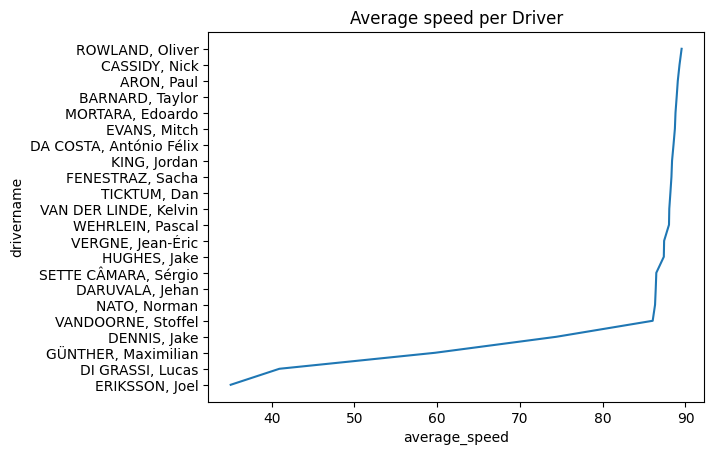

In [78]:
import seaborn as sns
sns.lineplot(y= 'drivername',
           x= 'average_speed',
           data= df2,
             palette = '#FF5733'
          ).set(title ='Average speed per Driver')